# Setup: Mount Drive and Install Dependencies

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Install required packages
!pip install -q styleGAN2-pytorch
!pip install -q torch torchvision
!pip install -q scikit-learn seaborn pandas numpy matplotlib pillow

Mounted at /content/gdrive
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 78.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.6 MB/s eta 0:00:00


# Import Libraries, Set Seeds, and Configure Device

In [2]:
import os
import random
import shutil
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB


# Define Directory Paths and Create Output Folders

In [3]:
# ---- Paths ----
BASE_DATA_DIR = Path("/content/gdrive/My Drive/ANN/HAM10000")
METADATA_CSV = BASE_DATA_DIR / "HAM10000_metadata.csv"
IMG_DIR_1 = BASE_DATA_DIR / "HAM10000_images_part_1"
IMG_DIR_2 = BASE_DATA_DIR / "HAM10000_images_part_2"

# Create output directories
OUTPUT_DIR = Path("/content/gdrive/My Drive/ANN/HAM10000/outputs")
GAN_OUTPUT_DIR = OUTPUT_DIR / "gan_samples"
CLASSIFIER_OUTPUT_DIR = OUTPUT_DIR / "classifier_results"
SYNTHETIC_DIR = OUTPUT_DIR / "synthetic_images"

for dir_path in [OUTPUT_DIR, GAN_OUTPUT_DIR, CLASSIFIER_OUTPUT_DIR, SYNTHETIC_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("All paths configured successfully!")

All paths configured successfully!


# Load and Explore Dataset Metadata

DATASET OVERVIEW

Total samples: 10015

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

First few rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

CLASS DISTRIBUTION
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


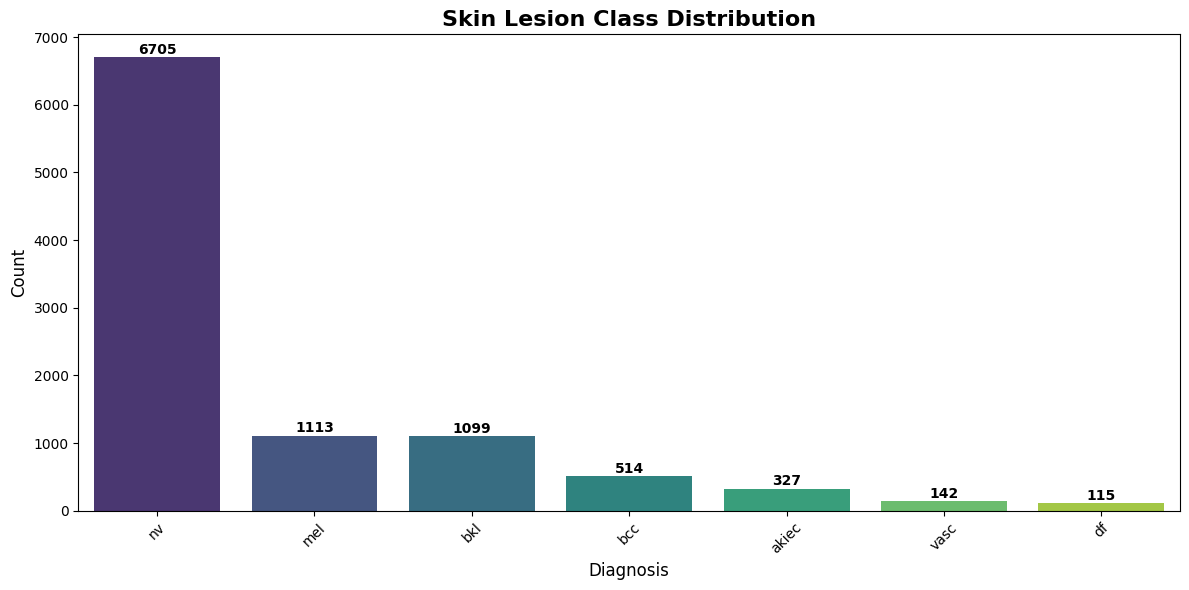


MISSING VALUES
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

AGE AND GENDER STATISTICS
Age - Mean: 51.86, Median: 50.00

Gender distribution:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

LOCALIZATION DISTRIBUTION
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


In [4]:
# Load metadata
df = pd.read_csv(METADATA_CSV)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nTotal samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print("\n" + "=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)
class_counts = df['dx'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Skin Lesion Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
print(df.isnull().sum())

print("\n" + "=" * 80)
print("AGE AND GENDER STATISTICS")
print("=" * 80)
print(f"Age - Mean: {df['age'].mean():.2f}, Median: {df['age'].median():.2f}")
print(f"\nGender distribution:")
print(df['sex'].value_counts())

print("\n" + "=" * 80)
print("LOCALIZATION DISTRIBUTION")
print("=" * 80)
print(df['localization'].value_counts())

# Map Image IDs to File Paths and Validate

In [5]:
# Create image_id to full path mapping
def get_image_path(image_id):
    """Get full path for image_id"""
    path1 = IMG_DIR_1 / f"{image_id}.jpg"
    path2 = IMG_DIR_2 / f"{image_id}.jpg"

    if path1.exists():
        return str(path1)
    elif path2.exists():
        return str(path2)
    else:
        return None

# Add full path column
df['image_path'] = df['image_id'].apply(get_image_path)

# Check for missing images
missing_images = df['image_path'].isnull().sum()
print(f"Missing images: {missing_images}")

if missing_images > 0:
    print("Removing samples with missing images...")
    df = df[df['image_path'].notnull()].reset_index(drop=True)

print(f"Total usable samples: {len(df)}")

Missing images: 0
Total usable samples: 10015


# Visualize Sample Images from Each Class

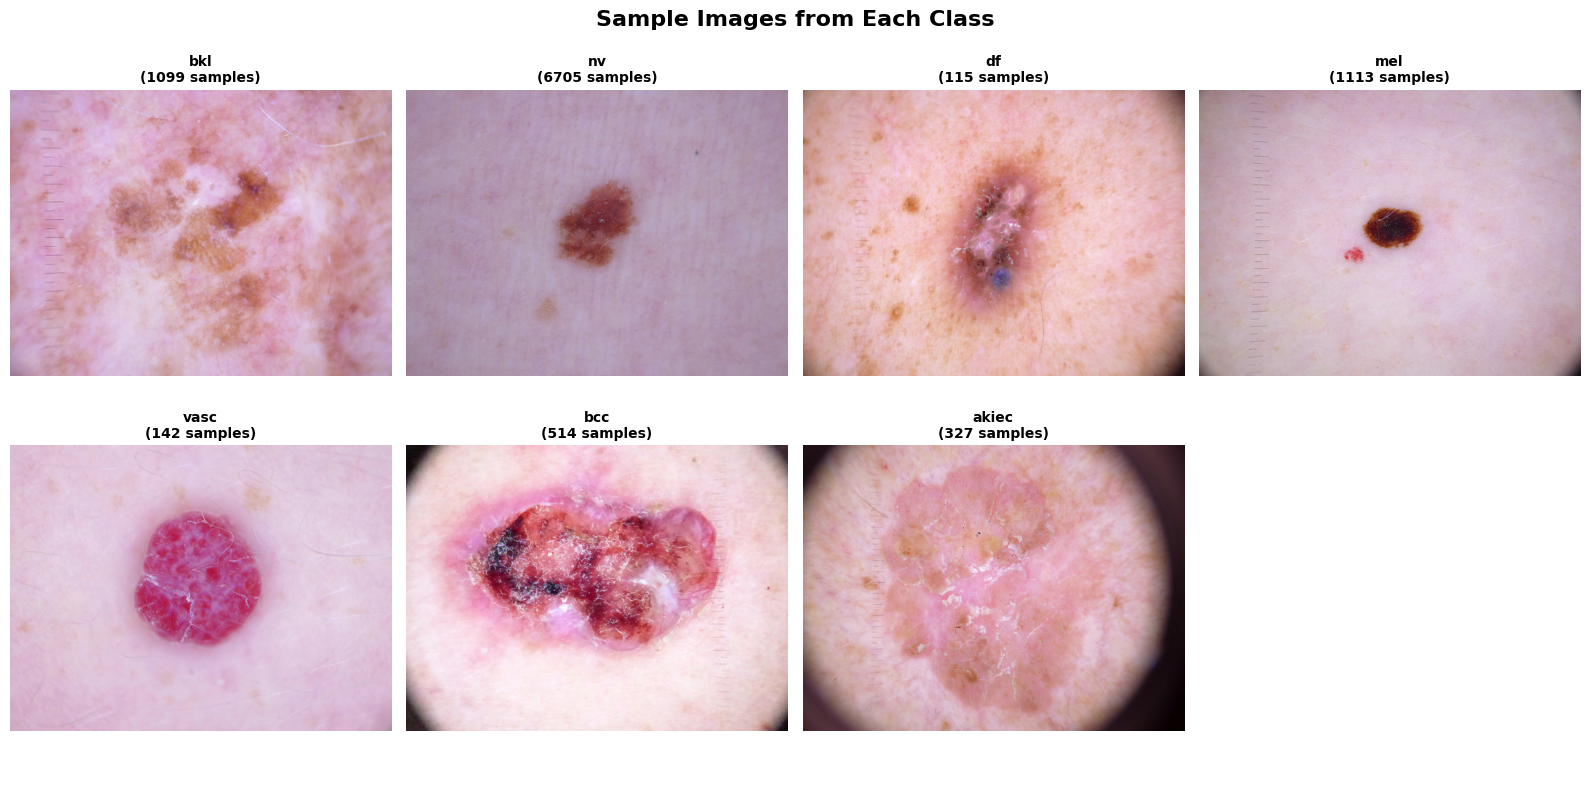

In [6]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

classes = df['dx'].unique()
for idx, cls in enumerate(classes[:7]):
    sample = df[df['dx'] == cls].iloc[0]
    img = Image.open(sample['image_path'])
    axes[idx].imshow(img)
    axes[idx].set_title(f"{cls}\n({class_counts[cls]} samples)", fontsize=10, fontweight='bold')
    axes[idx].axis('off')

# Remove extra subplot
axes[7].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

# Create Stratified Train/Validation/Test Splits

In [7]:
# Create stratified splits
print("Creating train/val/test splits...")

# First split: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['dx'],
    random_state=42
)

# Second split: 15% val, 15% test from temp
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['dx'],
    random_state=42
)

print(f"\nTrain samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print("\nTrain class distribution:")
print(train_df['dx'].value_counts())

print("\nMEL samples in train:", len(train_df[train_df['dx'] == 'mel']))

Creating train/val/test splits...

Train samples: 7010
Validation samples: 1502
Test samples: 1503

Train class distribution:
dx
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64

MEL samples in train: 779


# Define Custom Dataset Class for HAM10000

In [8]:
class HAM10000Dataset(Dataset):
    """Dataset for loading HAM10000 images"""

    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.df.iloc[idx]['dx']
        return image, label

# Test dataset
test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

test_dataset = HAM10000Dataset(train_df.head(5), transform=test_transform)
print(f"Dataset test successful! Sample shape: {test_dataset[0][0].shape}")

Dataset test successful! Sample shape: torch.Size([3, 128, 128])


# Define StyleGAN2 Generator Architecture

In [9]:
class MappingNetwork(nn.Module):
    """Maps latent z to intermediate latent w"""

    def __init__(self, latent_dim=512, hidden_dim=512, num_layers=8):
        super().__init__()

        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(latent_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(nn.LeakyReLU(0.2))

        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        return self.mapping(z)


class AdaIN(nn.Module):
    """Adaptive Instance Normalization"""

    def __init__(self, channels, w_dim):
        super().__init__()
        self.norm = nn.InstanceNorm2d(channels)
        self.style = nn.Linear(w_dim, channels * 2)

    def forward(self, x, w):
        style = self.style(w).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, dim=1)
        return gamma * self.norm(x) + beta


class StyleBlock(nn.Module):
    """StyleGAN2 synthesis block"""

    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

        self.activation = nn.LeakyReLU(0.2)

        # Noise inputs
        self.register_buffer('noise1', torch.randn(1, 1, 1, 1))
        self.register_buffer('noise2', torch.randn(1, 1, 1, 1))
        self.noise_weight1 = nn.Parameter(torch.zeros(1))
        self.noise_weight2 = nn.Parameter(torch.zeros(1))

    def forward(self, x, w):
        # First convolution
        x = self.conv1(x)
        x = x + self.noise_weight1 * self.noise1
        x = self.activation(x)
        x = self.adain1(x, w)

        # Second convolution
        x = self.conv2(x)
        x = x + self.noise_weight2 * self.noise2
        x = self.activation(x)
        x = self.adain2(x, w)

        return x


class Generator(nn.Module):
    """StyleGAN2-like Generator"""

    def __init__(self, latent_dim=512, w_dim=512, img_size=128):
        super().__init__()

        self.latent_dim = latent_dim
        self.w_dim = w_dim

        # Mapping network
        self.mapping = MappingNetwork(latent_dim, w_dim)

        # Starting constant
        self.constant = nn.Parameter(torch.randn(1, 512, 4, 4))

        # Progressive blocks
        self.blocks = nn.ModuleList([
            StyleBlock(512, 512, w_dim),  # 4x4
            StyleBlock(512, 512, w_dim),  # 8x8
            StyleBlock(512, 256, w_dim),  # 16x16
            StyleBlock(256, 128, w_dim),  # 32x32
            StyleBlock(128, 64, w_dim),   # 64x64
            StyleBlock(64, 32, w_dim),    # 128x128
        ])

        # To RGB layers
        self.to_rgb = nn.ModuleList([
            nn.Conv2d(512, 3, 1),
            nn.Conv2d(512, 3, 1),
            nn.Conv2d(256, 3, 1),
            nn.Conv2d(128, 3, 1),
            nn.Conv2d(64, 3, 1),
            nn.Conv2d(32, 3, 1),
        ])

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        # Map to intermediate latent
        w = self.mapping(z)

        # Start from constant
        x = self.constant.repeat(z.shape[0], 1, 1, 1)
        rgb = None

        # Progressive synthesis
        for i, (block, to_rgb_layer) in enumerate(zip(self.blocks, self.to_rgb)):
            x = block(x, w)

            # Convert to RGB
            new_rgb = to_rgb_layer(x)

            if rgb is not None:
                rgb = self.upsample(rgb) + new_rgb
            else:
                rgb = new_rgb

            # Upsample for next block (except last)
            if i < len(self.blocks) - 1:
                x = self.upsample(x)

        return torch.tanh(rgb)

# Test generator
gen = Generator(latent_dim=512, w_dim=512, img_size=128).to(device)
z = torch.randn(4, 512).to(device)
fake_imgs = gen(z)
print(f"Generator test successful! Output shape: {fake_imgs.shape}")
del gen, z, fake_imgs
torch.cuda.empty_cache()

Generator test successful! Output shape: torch.Size([4, 3, 128, 128])


# Define StyleGAN2 Discriminator Architecture

In [10]:
class Discriminator(nn.Module):
    """StyleGAN2-like Discriminator with minibatch stddev"""

    def __init__(self, img_size=128):
        super().__init__()

        # Progressive blocks (reverse of generator)
        self.from_rgb = nn.Sequential(
            nn.Conv2d(3, 32, 1),
            nn.LeakyReLU(0.2)
        )

        self.blocks = nn.ModuleList([
            self._make_block(32, 64),    # 128 -> 64
            self._make_block(64, 128),   # 64 -> 32
            self._make_block(128, 256),  # 32 -> 16
            self._make_block(256, 512),  # 16 -> 8
            self._make_block(512, 512),  # 8 -> 4
        ])

        # Minibatch stddev layer
        self.minibatch_std = MinibatchStdDev()

        # Final layers
        self.final_conv = nn.Conv2d(513, 512, 3, padding=1)
        self.final_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)
        )

    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )

    def forward(self, x):
        x = self.from_rgb(x)

        for block in self.blocks:
            x = block(x)

        # Add minibatch stddev
        x = self.minibatch_std(x)

        x = self.final_conv(x)
        x = self.final_linear(x)

        return x


class MinibatchStdDev(nn.Module):
    """Minibatch standard deviation layer"""

    def forward(self, x):
        batch_size, _, height, width = x.shape

        # Calculate stddev across batch
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2).mean(dim=0) + 1e-8)
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size, 1, height, width)

        return torch.cat([x, y], dim=1)

# Test discriminator
disc = Discriminator(img_size=128).to(device)
x = torch.randn(4, 3, 128, 128).to(device)
out = disc(x)
print(f"Discriminator test successful! Output shape: {out.shape}")
del disc, x, out
torch.cuda.empty_cache()

Discriminator test successful! Output shape: torch.Size([4, 1])


# Define GAN Training Functions (Gradient Penalty, Training Loop)

In [11]:
def compute_gradient_penalty(discriminator, real_images, fake_images, device):
    """Compute gradient penalty for WGAN-GP"""
    batch_size = real_images.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)

    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    d_interpolates = discriminator(interpolates)

    fake = torch.ones(batch_size, 1).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


def save_image_grid(images, path, nrow=8):
    """Save a grid of images"""
    from torchvision.utils import save_image
    save_image(images, path, nrow=nrow, normalize=True, value_range=(-1, 1))


def train_gan(generator, discriminator, dataloader, num_epochs, device,
              latent_dim=512, lr_g=0.0001, lr_d=0.0001, lambda_gp=10,
              n_critic=5, save_interval=10):
    """Train StyleGAN2 with WGAN-GP loss"""

    # Optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.0, 0.99))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.0, 0.99))

    # Fixed latent for visualization
    fixed_z = torch.randn(64, latent_dim).to(device)

    # Training history
    history = {
        'g_loss': [],
        'd_loss': [],
        'd_loss_real': [],
        'd_loss_fake': [],
        'gp': []
    }

    print("\n" + "=" * 80)
    print("STARTING GAN TRAINING")
    print("=" * 80)

    for epoch in range(num_epochs):
        g_losses = []
        d_losses = []
        d_real_losses = []
        d_fake_losses = []
        gp_losses = []

        for batch_idx, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # ---------------------
            # Train Discriminator
            # ---------------------
            for _ in range(n_critic):
                optimizer_d.zero_grad()

                # Real images
                d_real = discriminator(real_images)
                d_loss_real = -d_real.mean()

                # Fake images
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_images = generator(z)
                d_fake = discriminator(fake_images.detach())
                d_loss_fake = d_fake.mean()

                # Gradient penalty
                gp = compute_gradient_penalty(discriminator, real_images, fake_images.detach(), device)

                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake + lambda_gp * gp
                d_loss.backward()
                optimizer_d.step()

            # -----------------
            # Train Generator
            # -----------------
            optimizer_g.zero_grad()

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            g_fake = discriminator(fake_images)
            g_loss = -g_fake.mean()

            g_loss.backward()
            optimizer_g.step()

            # Record losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            d_real_losses.append(d_loss_real.item())
            d_fake_losses.append(d_loss_fake.item())
            gp_losses.append(gp.item())

        # Epoch statistics
        avg_g_loss = np.mean(g_losses)
        avg_d_loss = np.mean(d_losses)
        avg_d_real = np.mean(d_real_losses)
        avg_d_fake = np.mean(d_fake_losses)
        avg_gp = np.mean(gp_losses)

        history['g_loss'].append(avg_g_loss)
        history['d_loss'].append(avg_d_loss)
        history['d_loss_real'].append(avg_d_real)
        history['d_loss_fake'].append(avg_d_fake)
        history['gp'].append(avg_gp)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f} | "
              f"D(real): {avg_d_real:.4f} | D(fake): {avg_d_fake:.4f} | GP: {avg_gp:.4f}")

        # Save sample images
        if (epoch + 1) % save_interval == 0 or epoch == 0:
            generator.eval()
            with torch.no_grad():
                fake_samples = generator(fixed_z)
                save_image_grid(
                    fake_samples,
                    GAN_OUTPUT_DIR / f'epoch_{epoch+1:04d}.png',
                    nrow=8
                )
            generator.train()

    return history

# Train StyleGAN2 on MEL (Melanoma) Class Only

In [12]:
# Filter only MEL samples from training set
mel_train_df = train_df[train_df['dx'] == 'mel'].reset_index(drop=True)
print(f"MEL training samples: {len(mel_train_df)}")

# Transform for GAN training (resize to 128x128, normalize to [-1, 1])
gan_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # to [-1, 1]
])

# Create dataset and dataloader
mel_dataset = HAM10000Dataset(mel_train_df, transform=gan_transform)
mel_loader = DataLoader(mel_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)  # SMALLER BATCH

print(f"MEL DataLoader ready with {len(mel_loader)} batches")

# Initialize models
generator = Generator(latent_dim=512, w_dim=512, img_size=128).to(device)
discriminator = Discriminator(img_size=128).to(device)

# Count parameters
g_params = sum(p.numel() for p in generator.parameters())
d_params = sum(p.numel() for p in discriminator.parameters())
print(f"\nGenerator parameters: {g_params:,}")
print(f"Discriminator parameters: {d_params:,}")

#  IMPROVED TRAINING PARAMETERS
history = train_gan(
    generator=generator,
    discriminator=discriminator,
    dataloader=mel_loader,
    num_epochs=700,        # MORE EPOCHS
    device=device,
    latent_dim=512,
    lr_g=0.00005,          # LOWER G LEARNING RATE (was 0.0001)
    lr_d=0.00008,          # LOWER D LEARNING RATE (was 0.0001)
    lambda_gp=10,
    n_critic=3,            # FEWER CRITIC STEPS (was 5)
    save_interval=25
)

# Save trained models
torch.save(generator.state_dict(), OUTPUT_DIR / 'generator_mel_v2.pth')
torch.save(discriminator.state_dict(), OUTPUT_DIR / 'discriminator_mel_v2.pth')
print("\n✓ Models saved successfully!")

MEL training samples: 779
MEL DataLoader ready with 49 batches

Generator parameters: 16,990,462
Discriminator parameters: 15,981,569

STARTING GAN TRAINING
Epoch [1/700] | G Loss: 150.3011 | D Loss: -19.3604 | D(real): 134.7638 | D(fake): -164.8648 | GP: 1.0741
Epoch [2/700] | G Loss: 27.3385 | D Loss: 1.6511 | D(real): 23.8105 | D(fake): -28.3536 | GP: 0.6194
Epoch [3/700] | G Loss: 25.2290 | D Loss: 6.3998 | D(real): 19.0801 | D(fake): -20.0494 | GP: 0.7369
Epoch [4/700] | G Loss: -36.3597 | D Loss: 1.1246 | D(real): -24.8958 | D(fake): 23.1011 | GP: 0.2919
Epoch [5/700] | G Loss: -104.0552 | D Loss: -0.5396 | D(real): -95.7717 | D(fake): 91.6786 | GP: 0.3554
Epoch [6/700] | G Loss: 113.5054 | D Loss: 7.1752 | D(real): 74.6490 | D(fake): -84.6608 | GP: 1.7187
Epoch [7/700] | G Loss: 34.6260 | D Loss: -9.1847 | D(real): 40.9009 | D(fake): -53.7240 | GP: 0.3638
Epoch [8/700] | G Loss: -130.8868 | D Loss: -21.4950 | D(real): -183.1432 | D(fake): 154.0720 | GP: 0.7576
Epoch [9/700] | G 

# Plot and Save GAN Training History

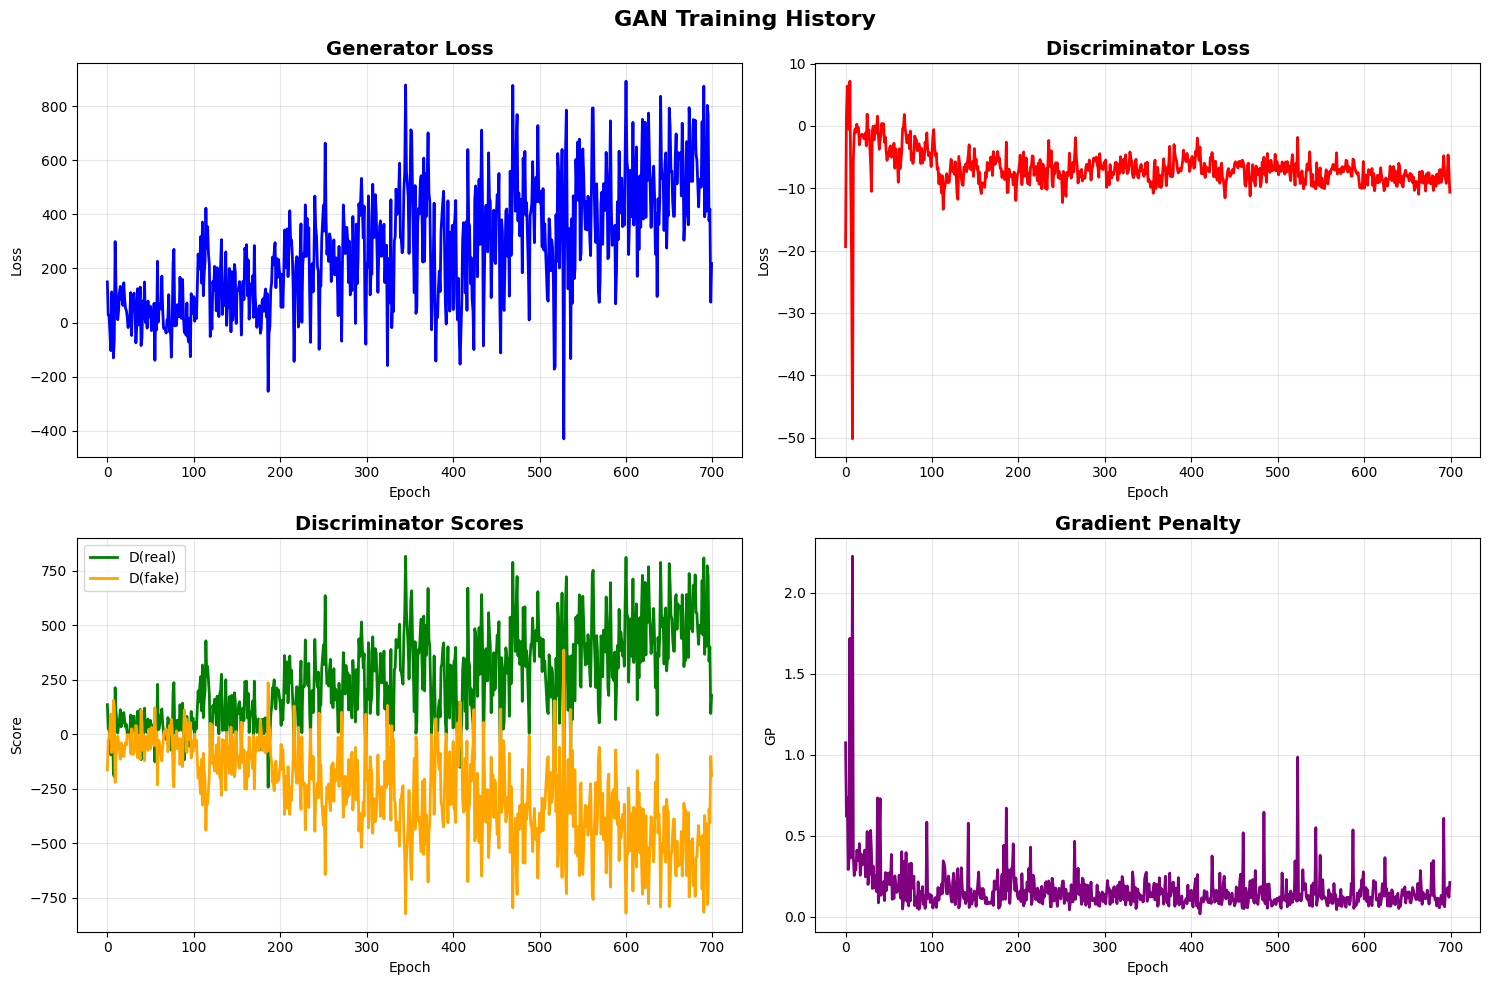

In [13]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Generator Loss
axes[0, 0].plot(history['g_loss'], linewidth=2, color='blue')
axes[0, 0].set_title('Generator Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Discriminator Loss
axes[0, 1].plot(history['d_loss'], linewidth=2, color='red')
axes[0, 1].set_title('Discriminator Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# D(real) and D(fake)
axes[1, 0].plot(history['d_loss_real'], label='D(real)', linewidth=2, color='green')
axes[1, 0].plot(history['d_loss_fake'], label='D(fake)', linewidth=2, color='orange')
axes[1, 0].set_title('Discriminator Scores', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gradient Penalty
axes[1, 1].plot(history['gp'], linewidth=2, color='purple')
axes[1, 1].set_title('Gradient Penalty', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('GP')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('GAN Training History', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gan_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate and Save Synthetic MEL Images

Generating 1000 synthetic MEL images...
Generated 256/1000 images
Generated 512/1000 images
Generated 768/1000 images
✓ Generated 1000 synthetic images
Saving synthetic images...
✓ Saved 1000 synthetic MEL images


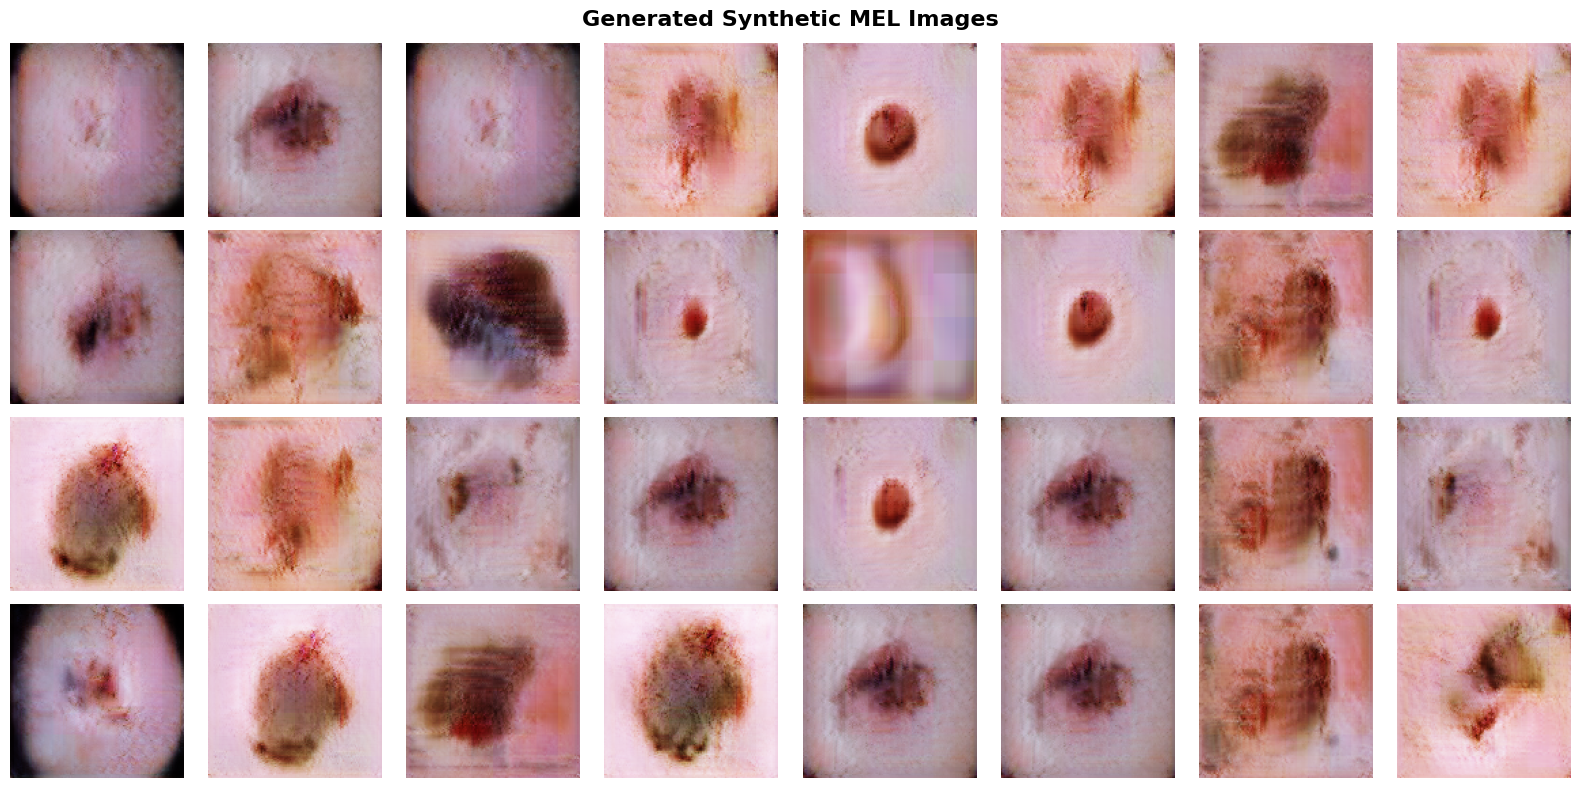

In [14]:
# Generate synthetic MEL images
num_synthetic = 1000  # Generate 1000 synthetic MEL images

print(f"Generating {num_synthetic} synthetic MEL images...")

generator.eval()
synthetic_images = []

with torch.no_grad():
    for i in range(0, num_synthetic, 64):
        batch_size = min(64, num_synthetic - i)
        z = torch.randn(batch_size, 512).to(device)
        fake_imgs = generator(z)

        # Denormalize from [-1, 1] to [0, 1]
        fake_imgs = (fake_imgs + 1) / 2.0

        synthetic_images.append(fake_imgs.cpu())

        if (i + batch_size) % 256 == 0:
            print(f"Generated {i + batch_size}/{num_synthetic} images")

synthetic_images = torch.cat(synthetic_images, dim=0)
print(f"✓ Generated {synthetic_images.shape[0]} synthetic images")

# Save synthetic images
print("Saving synthetic images...")
for idx, img in enumerate(synthetic_images):
    img_pil = transforms.ToPILImage()(img)
    img_pil.save(SYNTHETIC_DIR / f"synthetic_mel_{idx:05d}.jpg")

print(f"✓ Saved {len(synthetic_images)} synthetic MEL images")

# Visualize some synthetic images
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for idx in range(32):
    axes[idx].imshow(synthetic_images[idx].permute(1, 2, 0).numpy())
    axes[idx].axis('off')

plt.suptitle('Generated Synthetic MEL Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'synthetic_mel_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# Filter High-Quality Synthetic Images Using Discriminator Scores

FILTERING HIGH-QUALITY SYNTHETIC IMAGES

Evaluating 1000 synthetic images...
  Processed 200/1000 images
  Processed 400/1000 images
  Processed 600/1000 images
  Processed 800/1000 images
  Processed 1000/1000 images

✓ Selected TOP 300 images out of 1000
Score range: 1850.9559 to 1936.2573
✓ Saved 300 filtered images to /content/gdrive/My Drive/ANN/HAM10000/outputs/filtered_synthetic


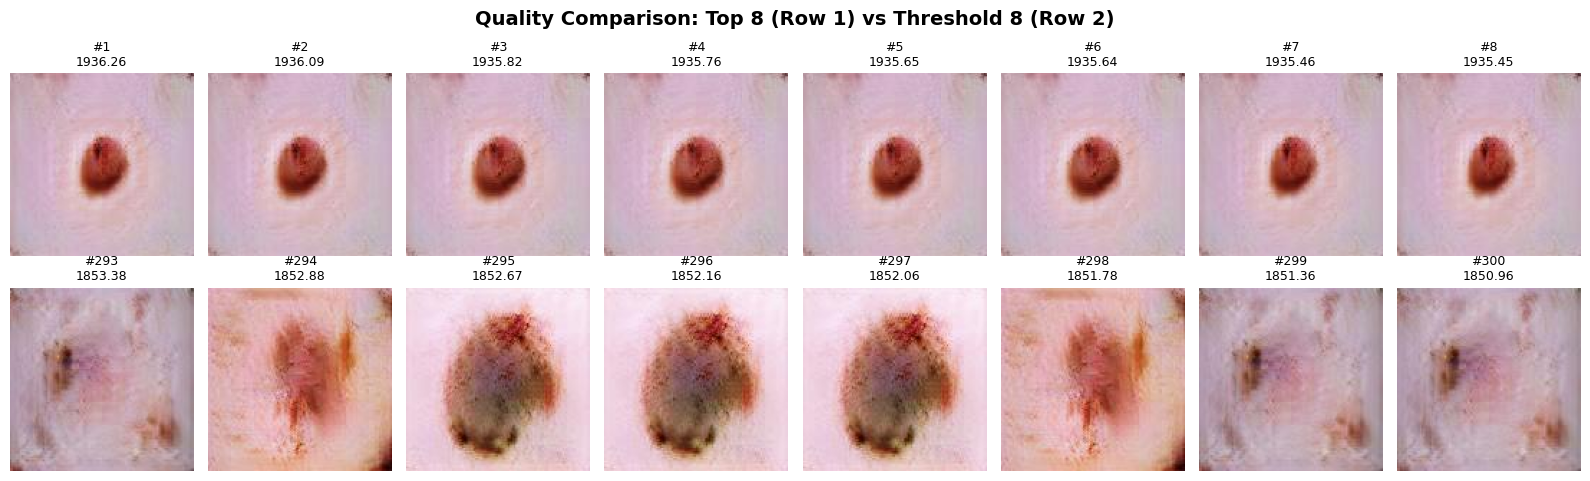

In [15]:
print("=" * 80)
print("FILTERING HIGH-QUALITY SYNTHETIC IMAGES")
print("=" * 80)

# Load discriminator for quality scoring
discriminator.load_state_dict(torch.load(OUTPUT_DIR / 'discriminator_mel_v2.pth'))
discriminator.eval()

quality_scores = []
synthetic_paths = sorted(list(SYNTHETIC_DIR.glob("*.jpg")))

print(f"\nEvaluating {len(synthetic_paths)} synthetic images...")

with torch.no_grad():
    for idx, img_path in enumerate(synthetic_paths):
        img = Image.open(img_path).convert('RGB')
        img_tensor = gan_transform(img).unsqueeze(0).to(device)
        score = discriminator(img_tensor).item()
        quality_scores.append((img_path, score))

        if (idx + 1) % 200 == 0:
            print(f"  Processed {idx + 1}/{len(synthetic_paths)} images")

# Sort by discriminator score (higher = more realistic)
quality_scores.sort(key=lambda x: x[1], reverse=True)

# Calculate threshold: keep top 30% OR max 300 images
num_to_keep = min(300, int(len(quality_scores) * 0.3))
top_synthetic = quality_scores[:num_to_keep]

print(f"\n✓ Selected TOP {len(top_synthetic)} images out of {len(quality_scores)}")
print(f"Score range: {top_synthetic[-1][1]:.4f} to {top_synthetic[0][1]:.4f}")

# Create filtered directory
FILTERED_SYNTHETIC_DIR = OUTPUT_DIR / "filtered_synthetic"
FILTERED_SYNTHETIC_DIR.mkdir(exist_ok=True)

# Save only high-quality synthetics
for idx, (img_path, score) in enumerate(top_synthetic):
    img = Image.open(img_path)
    img.save(FILTERED_SYNTHETIC_DIR / f"filtered_mel_{idx:05d}.jpg")

print(f"✓ Saved {len(top_synthetic)} filtered images to {FILTERED_SYNTHETIC_DIR}")

# Visualize quality comparison
fig, axes = plt.subplots(2, 8, figsize=(16, 5))

# Top 8 (best quality)
for i in range(8):
    img = Image.open(top_synthetic[i][0])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"#{i+1}\n{top_synthetic[i][1]:.2f}", fontsize=9)
    axes[0, i].axis('off')

# Bottom 8 (worst of the "good")
for i in range(8):
    idx = num_to_keep - 8 + i
    img = Image.open(top_synthetic[idx][0])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"#{idx+1}\n{top_synthetic[idx][1]:.2f}", fontsize=9)
    axes[1, i].axis('off')

plt.suptitle('Quality Comparison: Top 8 (Row 1) vs Threshold 8 (Row 2)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'quality_filtering.png', dpi=300, bbox_inches='tight')
plt.show()

# Define Classifier Datasets and Transforms

In [16]:
class HAM10000ClassifierDataset(Dataset):
    """Dataset for classifier with ImageNet normalization"""

    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

        # Class to index mapping
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(df['dx'].unique()))}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.df.iloc[idx]['dx']]

        if self.transform:
            image = self.transform(image)

        return image, label


class SyntheticMELDataset(Dataset):
    """Dataset for synthetic MEL images"""

    def __init__(self, synthetic_dir, transform=None, class_to_idx=None):
        self.synthetic_dir = Path(synthetic_dir)
        self.image_files = sorted(list(self.synthetic_dir.glob("*.jpg")))
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.mel_idx = class_to_idx['mel']

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.mel_idx


# Transforms for classifier
train_transform_classifier = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform_classifier = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Classifier transforms defined!")

Classifier transforms defined!


# Create Baseline Classifier Datasets (No Synthetic Data)

In [17]:
print("=" * 80)
print("BASELINE CLASSIFIER (WITHOUT SYNTHETIC DATA)")
print("=" * 80)

# Create datasets
train_dataset_baseline = HAM10000ClassifierDataset(train_df, transform=train_transform_classifier)
val_dataset = HAM10000ClassifierDataset(val_df, transform=val_transform_classifier)
test_dataset = HAM10000ClassifierDataset(test_df, transform=val_transform_classifier)

# Create dataloaders
train_loader_baseline = DataLoader(train_dataset_baseline, batch_size=64, shuffle=True,
                                    num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                         num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader_baseline)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Get class info
num_classes = len(train_dataset_baseline.class_to_idx)
class_to_idx = train_dataset_baseline.class_to_idx
idx_to_class = train_dataset_baseline.idx_to_class

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {list(class_to_idx.keys())}")

BASELINE CLASSIFIER (WITHOUT SYNTHETIC DATA)
Train batches: 110
Val batches: 24
Test batches: 24

Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


# Define ResNet50 Classifier with Transfer Learning

In [18]:
def create_resnet50_classifier(num_classes, pretrained=True):
    """Create ResNet50 classifier with transfer learning"""

    if pretrained:
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    else:
        model = resnet50(weights=None)

    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze layer4 and later
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace final layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

    return model

# Test model
model_test = create_resnet50_classifier(num_classes).to(device)
trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_test.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
del model_test
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


Total parameters: 24,560,711
Trainable parameters: 16,017,415


# Define Classifier Training Function with Early Stopping

In [19]:
def train_classifier(model, train_loader, val_loader, num_epochs, device,
                     lr=0.001, patience=15):
    """Train ResNet50 classifier"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                                       patience=5)

    best_val_acc = 0.0
    patience_counter = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print("\n" + "=" * 80)
    print("STARTING CLASSIFIER TRAINING")
    print("=" * 80)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100.0 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100.0 * val_correct / val_total

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Learning rate scheduling
        scheduler.step(val_acc)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), CLASSIFIER_OUTPUT_DIR / 'best_model.pth')
            patience_counter = 0
            print(f"✓ New best model saved! Val Acc: {best_val_acc:.2f}%")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    print(f"\n✓ Training complete! Best Val Acc: {best_val_acc:.2f}%")
    return history, best_val_acc

# Train Baseline Classifier Model

In [20]:
# Train baseline model
model_baseline = create_resnet50_classifier(num_classes, pretrained=True).to(device)

history_baseline, best_acc_baseline = train_classifier(
    model=model_baseline,
    train_loader=train_loader_baseline,
    val_loader=val_loader,
    num_epochs=100,  # High epochs with early stopping
    device=device,
    lr=0.001,
    patience=15
)

# Load best model
model_baseline.load_state_dict(torch.load(CLASSIFIER_OUTPUT_DIR / 'best_model.pth'))
print("\n✓ Baseline model training complete!")


STARTING CLASSIFIER TRAINING
Epoch [1/100] | Train Loss: 0.7771 | Train Acc: 72.52% | Val Loss: 0.5691 | Val Acc: 81.16%
✓ New best model saved! Val Acc: 81.16%
Epoch [2/100] | Train Loss: 0.5674 | Train Acc: 80.14% | Val Loss: 0.4774 | Val Acc: 83.95%
✓ New best model saved! Val Acc: 83.95%
Epoch [3/100] | Train Loss: 0.4682 | Train Acc: 83.21% | Val Loss: 0.4527 | Val Acc: 84.95%
✓ New best model saved! Val Acc: 84.95%
Epoch [4/100] | Train Loss: 0.4135 | Train Acc: 85.06% | Val Loss: 0.4520 | Val Acc: 85.42%
✓ New best model saved! Val Acc: 85.42%
Epoch [5/100] | Train Loss: 0.3676 | Train Acc: 86.43% | Val Loss: 0.4321 | Val Acc: 85.49%
✓ New best model saved! Val Acc: 85.49%
Epoch [6/100] | Train Loss: 0.3327 | Train Acc: 87.63% | Val Loss: 0.4626 | Val Acc: 85.55%
✓ New best model saved! Val Acc: 85.55%
Epoch [7/100] | Train Loss: 0.3043 | Train Acc: 88.92% | Val Loss: 0.4344 | Val Acc: 85.95%
✓ New best model saved! Val Acc: 85.95%
Epoch [8/100] | Train Loss: 0.2696 | Train Acc

# Define and Run Comprehensive Model Evaluation

In [21]:
def evaluate_model(model, test_loader, device, idx_to_class):
    """Comprehensive evaluation of classifier"""

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)

    # Per-class metrics
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # Macro averages
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    specificity = []

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate specificity and BMA for each class
    for i in range(len(idx_to_class)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    specificity = np.array(specificity)
    sensitivity = recall_per_class  # Sensitivity = Recall

    # Balanced Multi-class Accuracy (BMA)
    bma = np.mean((sensitivity + specificity) / 2)

    results = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'bma': bma,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

    return results

print("=" * 80)
print("BASELINE MODEL EVALUATION")
print("=" * 80)

results_baseline = evaluate_model(model_baseline, test_loader, device, idx_to_class)

print(f"\nOverall Accuracy: {results_baseline['accuracy']*100:.2f}%")
print(f"Macro Precision: {results_baseline['precision_macro']*100:.2f}%")
print(f"Macro Recall (Sensitivity): {results_baseline['recall_macro']*100:.2f}%")
print(f"BMA (Balanced Multi-class Accuracy): {results_baseline['bma']*100:.2f}%")

print("\nPer-Class Metrics:")
print("-" * 80)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'F1-Score':<12}")
print("-" * 80)
for idx, cls in idx_to_class.items():
    print(f"{cls:<10} {results_baseline['precision_per_class'][idx]*100:>10.2f}%  "
          f"{results_baseline['sensitivity'][idx]*100:>10.2f}%  "
          f"{results_baseline['specificity'][idx]*100:>10.2f}%  "
          f"{results_baseline['f1_per_class'][idx]*100:>10.2f}%")

BASELINE MODEL EVALUATION

Overall Accuracy: 87.43%
Macro Precision: 78.24%
Macro Recall (Sensitivity): 78.16%
BMA (Balanced Multi-class Accuracy): 87.48%

Per-Class Metrics:
--------------------------------------------------------------------------------
Class      Precision    Recall       Specificity  F1-Score    
--------------------------------------------------------------------------------
akiec           73.47%       73.47%       99.11%       73.47%
bcc             69.79%       87.01%       97.97%       77.46%
bkl             73.72%       69.70%       96.94%       71.65%
df              68.75%       64.71%       99.66%       66.67%
mel             77.62%       66.47%       97.60%       71.61%
nv              93.44%       94.83%       86.52%       94.13%
vasc            90.91%       90.91%       99.86%       90.91%


# Train Augmented Classifier with Filtered Synthetic Data

In [22]:
print("\n" + "=" * 80)
print("AUGMENTED CLASSIFIER (WITH FILTERED SYNTHETIC MEL DATA)")
print("=" * 80)

# Create synthetic dataset using FILTERED directory
synthetic_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Use FILTERED_SYNTHETIC_DIR instead of SYNTHETIC_DIR
filtered_synthetic_dataset = SyntheticMELDataset(
    FILTERED_SYNTHETIC_DIR,  # ⚡ CHANGED FROM SYNTHETIC_DIR
    transform=synthetic_transform,
    class_to_idx=class_to_idx
)

# Combine real and FILTERED synthetic datasets
from torch.utils.data import ConcatDataset

train_dataset_augmented = ConcatDataset([train_dataset_baseline, filtered_synthetic_dataset])
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True,
                                     num_workers=2, pin_memory=True)

print(f"Baseline training samples: {len(train_dataset_baseline)}")
print(f"Filtered synthetic MEL samples: {len(filtered_synthetic_dataset)}")
print(f"Total augmented training samples: {len(train_dataset_augmented)}")
print(f"Synthetic ratio: {len(filtered_synthetic_dataset)/len(mel_train_df)*100:.1f}% of real MEL data")
print(f"Augmented train batches: {len(train_loader_augmented)}")

# Train augmented model
model_augmented = create_resnet50_classifier(num_classes, pretrained=True).to(device)

history_augmented, best_acc_augmented = train_classifier(
    model=model_augmented,
    train_loader=train_loader_augmented,
    val_loader=val_loader,
    num_epochs=100,
    device=device,
    lr=0.001,
    patience=15
)

# Save both models with clear names
torch.save(model_augmented.state_dict(), CLASSIFIER_OUTPUT_DIR / 'best_model_augmented_filtered.pth')
torch.save(model_baseline.state_dict(), CLASSIFIER_OUTPUT_DIR / 'best_model_baseline.pth')

print("\n✓ Augmented model (filtered) training complete!")


AUGMENTED CLASSIFIER (WITH FILTERED SYNTHETIC MEL DATA)
Baseline training samples: 7010
Filtered synthetic MEL samples: 300
Total augmented training samples: 7310
Synthetic ratio: 38.5% of real MEL data
Augmented train batches: 115

STARTING CLASSIFIER TRAINING
Epoch [1/100] | Train Loss: 0.7434 | Train Acc: 73.79% | Val Loss: 0.5450 | Val Acc: 81.16%
✓ New best model saved! Val Acc: 81.16%
Epoch [2/100] | Train Loss: 0.5423 | Train Acc: 81.01% | Val Loss: 0.5567 | Val Acc: 82.22%
✓ New best model saved! Val Acc: 82.22%
Epoch [3/100] | Train Loss: 0.4528 | Train Acc: 83.78% | Val Loss: 0.4634 | Val Acc: 84.42%
✓ New best model saved! Val Acc: 84.42%
Epoch [4/100] | Train Loss: 0.4145 | Train Acc: 84.98% | Val Loss: 0.4456 | Val Acc: 85.35%
✓ New best model saved! Val Acc: 85.35%
Epoch [5/100] | Train Loss: 0.3562 | Train Acc: 87.35% | Val Loss: 0.3683 | Val Acc: 86.68%
✓ New best model saved! Val Acc: 86.68%
Epoch [6/100] | Train Loss: 0.3200 | Train Acc: 88.25% | Val Loss: 0.5268 | V

# Evaluate Augmented Model on Test Set

In [23]:
print("=" * 80)
print("AUGMENTED MODEL EVALUATION")
print("=" * 80)

results_augmented = evaluate_model(model_augmented, test_loader, device, idx_to_class)

print(f"\nOverall Accuracy: {results_augmented['accuracy']*100:.2f}%")
print(f"Macro Precision: {results_augmented['precision_macro']*100:.2f}%")
print(f"Macro Recall (Sensitivity): {results_augmented['recall_macro']*100:.2f}%")
print(f"BMA (Balanced Multi-class Accuracy): {results_augmented['bma']*100:.2f}%")

print("\nPer-Class Metrics:")
print("-" * 80)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'F1-Score':<12}")
print("-" * 80)
for idx, cls in idx_to_class.items():
    print(f"{cls:<10} {results_augmented['precision_per_class'][idx]*100:>10.2f}%  "
          f"{results_augmented['sensitivity'][idx]*100:>10.2f}%  "
          f"{results_augmented['specificity'][idx]*100:>10.2f}%  "
          f"{results_augmented['f1_per_class'][idx]*100:>10.2f}%")

AUGMENTED MODEL EVALUATION

Overall Accuracy: 90.55%
Macro Precision: 89.66%
Macro Recall (Sensitivity): 79.90%
BMA (Balanced Multi-class Accuracy): 88.61%

Per-Class Metrics:
--------------------------------------------------------------------------------
Class      Precision    Recall       Specificity  F1-Score    
--------------------------------------------------------------------------------
akiec           82.98%       79.59%       99.45%       81.25%
bcc             90.67%       88.31%       99.51%       89.47%
bkl             81.25%       78.79%       97.76%       80.00%
df             100.00%       52.94%      100.00%       69.23%
mel             78.95%       71.86%       97.60%       75.24%
nv              93.75%       96.92%       86.92%       95.31%
vasc           100.00%       90.91%      100.00%       95.24%


# Compare Baseline vs Augmented Model Performance

In [24]:
print("\n" + "=" * 80)
print("THREE-WAY MODEL COMPARISON")
print("=" * 80)

# Create comprehensive comparison
comparison_3way = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'Specificity (Macro)', 'BMA'],
    'Baseline': [
        results_baseline['accuracy'] * 100,
        results_baseline['precision_macro'] * 100,
        results_baseline['recall_macro'] * 100,
        np.mean(results_baseline['specificity']) * 100,
        results_baseline['bma'] * 100
    ],
    'Augmented (All 1000)': [
        results_augmented['accuracy'] * 100,
        results_augmented['precision_macro'] * 100,
        results_augmented['recall_macro'] * 100,
        np.mean(results_augmented['specificity']) * 100,
        results_augmented['bma'] * 100
    ]
})

comparison_3way['Improvement (All)'] = comparison_3way['Augmented (All 1000)'] - comparison_3way['Baseline']

print(comparison_3way.to_string(index=False))

# MEL-specific comparison
mel_idx = class_to_idx['mel']
print("\n" + "-" * 80)
print("MEL (MELANOMA) CLASS PERFORMANCE")
print("-" * 80)

mel_comparison = pd.DataFrame({
    'Model': ['Baseline', 'Augmented (All 1000)'],
    'Precision (%)': [
        results_baseline['precision_per_class'][mel_idx] * 100,
        results_augmented['precision_per_class'][mel_idx] * 100
    ],
    'Recall (%)': [
        results_baseline['sensitivity'][mel_idx] * 100,
        results_augmented['sensitivity'][mel_idx] * 100
    ],
    'Specificity (%)': [
        results_baseline['specificity'][mel_idx] * 100,
        results_augmented['specificity'][mel_idx] * 100
    ],
    'F1-Score (%)': [
        results_baseline['f1_per_class'][mel_idx] * 100,
        results_augmented['f1_per_class'][mel_idx] * 100
    ]
})

print(mel_comparison.to_string(index=False))

# Save comparison
comparison_3way.to_csv(CLASSIFIER_OUTPUT_DIR / 'model_comparison_3way.csv', index=False)
mel_comparison.to_csv(CLASSIFIER_OUTPUT_DIR / 'mel_comparison.csv', index=False)
print("\n✓ Comparisons saved!")


THREE-WAY MODEL COMPARISON
             Metric  Baseline  Augmented (All 1000)  Improvement (All)
           Accuracy 87.425150             90.552229           3.127079
  Precision (Macro) 78.242611             89.656108          11.413497
     Recall (Macro) 78.156057             79.902350           1.746293
Specificity (Macro) 96.808624             97.320440           0.511816
                BMA 87.482340             88.611395           1.129054

--------------------------------------------------------------------------------
MEL (MELANOMA) CLASS PERFORMANCE
--------------------------------------------------------------------------------
               Model  Precision (%)  Recall (%)  Specificity (%)  F1-Score (%)
            Baseline      77.622378   66.467066         97.60479     71.612903
Augmented (All 1000)      78.947368   71.856287         97.60479     75.235110

✓ Comparisons saved!


# Train Classifier with All 1000 Unfiltered Synthetic Images

In [25]:
print("=" * 80)
print("CLASSIFIER WITH ALL 1000 SYNTHETIC IMAGES")
print("=" * 80)

# Create synthetic dataset with ALL 1000 images
synthetic_transform_all = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Use SYNTHETIC_DIR (all 1000 images) instead of filtered
synthetic_dataset_all = SyntheticMELDataset(
    SYNTHETIC_DIR,  # All 1000 images
    transform=synthetic_transform_all,
    class_to_idx=class_to_idx
)

# Combine real and ALL synthetic datasets
train_dataset_all_synthetic = ConcatDataset([train_dataset_baseline, synthetic_dataset_all])
train_loader_all_synthetic = DataLoader(train_dataset_all_synthetic, batch_size=64, shuffle=True,
                                         num_workers=2, pin_memory=True)

print(f"Baseline training samples: {len(train_dataset_baseline)}")
print(f"All synthetic MEL samples: {len(synthetic_dataset_all)}")
print(f"Total training samples: {len(train_dataset_all_synthetic)}")
print(f"Synthetic ratio: {len(synthetic_dataset_all)/len(mel_train_df)*100:.1f}% of real MEL data")

# Train classifier with all 1000 synthetic images
model_all_synthetic = create_resnet50_classifier(num_classes, pretrained=True).to(device)

history_all_synthetic, best_acc_all_synthetic = train_classifier(
    model=model_all_synthetic,
    train_loader=train_loader_all_synthetic,
    val_loader=val_loader,
    num_epochs=100,
    device=device,
    lr=0.001,
    patience=15
)

# Load best model
model_all_synthetic.load_state_dict(torch.load(CLASSIFIER_OUTPUT_DIR / 'best_model.pth'))

# Save with clear name
torch.save(model_all_synthetic.state_dict(), CLASSIFIER_OUTPUT_DIR / 'best_model_all_1000.pth')

print("\n✓ Classifier with ALL 1000 synthetic images training complete!")

CLASSIFIER WITH ALL 1000 SYNTHETIC IMAGES
Baseline training samples: 7010
All synthetic MEL samples: 1000
Total training samples: 8010
Synthetic ratio: 128.4% of real MEL data

STARTING CLASSIFIER TRAINING
Epoch [1/100] | Train Loss: 0.6722 | Train Acc: 76.48% | Val Loss: 0.6245 | Val Acc: 78.10%
✓ New best model saved! Val Acc: 78.10%
Epoch [2/100] | Train Loss: 0.4876 | Train Acc: 82.63% | Val Loss: 0.4835 | Val Acc: 82.89%
✓ New best model saved! Val Acc: 82.89%
Epoch [3/100] | Train Loss: 0.4048 | Train Acc: 84.89% | Val Loss: 0.4391 | Val Acc: 84.55%
✓ New best model saved! Val Acc: 84.55%
Epoch [4/100] | Train Loss: 0.3722 | Train Acc: 86.53% | Val Loss: 0.3792 | Val Acc: 86.62%
✓ New best model saved! Val Acc: 86.62%
Epoch [5/100] | Train Loss: 0.3231 | Train Acc: 88.36% | Val Loss: 0.5256 | Val Acc: 83.49%
Epoch [6/100] | Train Loss: 0.3018 | Train Acc: 88.95% | Val Loss: 0.4327 | Val Acc: 86.22%
Epoch [7/100] | Train Loss: 0.2774 | Train Acc: 89.89% | Val Loss: 0.4101 | Val Ac

# Evaluate Model Trained with All 1000 Synthetic Images

In [26]:
print("=" * 80)
print("EVALUATION: MODEL WITH ALL 1000 SYNTHETIC IMAGES")
print("=" * 80)

results_all_synthetic = evaluate_model(model_all_synthetic, test_loader, device, idx_to_class)

print(f"\nOverall Accuracy: {results_all_synthetic['accuracy']*100:.2f}%")
print(f"Macro Precision: {results_all_synthetic['precision_macro']*100:.2f}%")
print(f"Macro Recall (Sensitivity): {results_all_synthetic['recall_macro']*100:.2f}%")
print(f"BMA (Balanced Multi-class Accuracy): {results_all_synthetic['bma']*100:.2f}%")

print("\nPer-Class Metrics:")
print("-" * 80)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'F1-Score':<12}")
print("-" * 80)
for idx, cls in idx_to_class.items():
    print(f"{cls:<10} {results_all_synthetic['precision_per_class'][idx]*100:>10.2f}%  "
          f"{results_all_synthetic['sensitivity'][idx]*100:>10.2f}%  "
          f"{results_all_synthetic['specificity'][idx]*100:>10.2f}%  "
          f"{results_all_synthetic['f1_per_class'][idx]*100:>10.2f}%")

EVALUATION: MODEL WITH ALL 1000 SYNTHETIC IMAGES

Overall Accuracy: 89.29%
Macro Precision: 87.29%
Macro Recall (Sensitivity): 78.60%
BMA (Balanced Multi-class Accuracy): 87.82%

Per-Class Metrics:
--------------------------------------------------------------------------------
Class      Precision    Recall       Specificity  F1-Score    
--------------------------------------------------------------------------------
akiec           74.00%       75.51%       99.11%       74.75%
bcc             86.42%       90.91%       99.23%       88.61%
bkl             85.93%       70.30%       98.58%       77.33%
df             100.00%       58.82%      100.00%       74.07%
mel             71.43%       71.86%       96.41%       71.64%
nv              93.27%       96.42%       85.92%       94.82%
vasc           100.00%       86.36%      100.00%       92.68%


# Final Three-Way Comparison: Baseline vs Filtered vs All Synthetic

In [27]:
print("\n" + "=" * 80)
print("COMPLETE THREE-WAY MODEL COMPARISON")
print("=" * 80)

# Create comprehensive comparison
comparison_complete = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'Specificity (Macro)', 'BMA'],
    'Baseline': [
        results_baseline['accuracy'] * 100,
        results_baseline['precision_macro'] * 100,
        results_baseline['recall_macro'] * 100,
        np.mean(results_baseline['specificity']) * 100,
        results_baseline['bma'] * 100
    ],
    'Filtered (300)': [
        results_augmented['accuracy'] * 100,
        results_augmented['precision_macro'] * 100,
        results_augmented['recall_macro'] * 100,
        np.mean(results_augmented['specificity']) * 100,
        results_augmented['bma'] * 100
    ],
    'All (1000)': [
        results_all_synthetic['accuracy'] * 100,
        results_all_synthetic['precision_macro'] * 100,
        results_all_synthetic['recall_macro'] * 100,
        np.mean(results_all_synthetic['specificity']) * 100,
        results_all_synthetic['bma'] * 100
    ]
})

comparison_complete['Δ Filtered'] = comparison_complete['Filtered (300)'] - comparison_complete['Baseline']
comparison_complete['Δ All'] = comparison_complete['All (1000)'] - comparison_complete['Baseline']

print(comparison_complete.to_string(index=False))

# Save comparison
comparison_complete.to_csv(CLASSIFIER_OUTPUT_DIR / 'complete_model_comparison.csv', index=False)
print("\n✓ Complete comparison saved!")

# Highlight best performer
print("\n" + "=" * 80)
print("BEST PERFORMER PER METRIC")
print("=" * 80)
for idx, row in comparison_complete.iterrows():
    if idx < 5:  # Only for metric rows
        metric = row['Metric']
        best_val = max(row['Baseline'], row['Filtered (300)'], row['All (1000)'])

        if row['Baseline'] == best_val:
            best_model = 'Baseline'
        elif row['Filtered (300)'] == best_val:
            best_model = 'Filtered (300)'
        else:
            best_model = 'All (1000)'

        print(f"{metric:<25} → {best_model:<15} ({best_val:.2f}%)")


COMPLETE THREE-WAY MODEL COMPARISON
             Metric  Baseline  Filtered (300)  All (1000)  Δ Filtered    Δ All
           Accuracy 87.425150       90.552229   89.288090    3.127079 1.862941
  Precision (Macro) 78.242611       89.656108   87.291926   11.413497 9.049315
     Recall (Macro) 78.156057       79.902350   78.598179    1.746293 0.442122
Specificity (Macro) 96.808624       97.320440   97.033882    0.511816 0.225258
                BMA 87.482340       88.611395   87.816030    1.129054 0.333690

✓ Complete comparison saved!

BEST PERFORMER PER METRIC
Accuracy                  → Filtered (300)  (90.55%)
Precision (Macro)         → Filtered (300)  (89.66%)
Recall (Macro)            → Filtered (300)  (79.90%)
Specificity (Macro)       → Filtered (300)  (97.32%)
BMA                       → Filtered (300)  (88.61%)


# Detailed MEL Class Comparison Across All Three Models

In [28]:
print("\n" + "=" * 80)
print("MEL (MELANOMA) - DETAILED THREE-WAY COMPARISON")
print("=" * 80)

mel_idx = class_to_idx['mel']

mel_comparison_complete = pd.DataFrame({
    'Model': ['Baseline', 'Filtered (300)', 'All (1000)'],
    'Precision (%)': [
        results_baseline['precision_per_class'][mel_idx] * 100,
        results_augmented['precision_per_class'][mel_idx] * 100,
        results_all_synthetic['precision_per_class'][mel_idx] * 100
    ],
    'Recall (%)': [
        results_baseline['sensitivity'][mel_idx] * 100,
        results_augmented['sensitivity'][mel_idx] * 100,
        results_all_synthetic['sensitivity'][mel_idx] * 100
    ],
    'Specificity (%)': [
        results_baseline['specificity'][mel_idx] * 100,
        results_augmented['specificity'][mel_idx] * 100,
        results_all_synthetic['specificity'][mel_idx] * 100
    ],
    'F1-Score (%)': [
        results_baseline['f1_per_class'][mel_idx] * 100,
        results_augmented['f1_per_class'][mel_idx] * 100,
        results_all_synthetic['f1_per_class'][mel_idx] * 100
    ]
})

print(mel_comparison_complete.to_string(index=False))

# Calculate improvements
print("\n" + "-" * 80)
print("IMPROVEMENTS FROM BASELINE:")
print("-" * 80)

for idx in [1, 2]:  # Filtered and All
    model_name = mel_comparison_complete.iloc[idx]['Model']
    recall_improvement = mel_comparison_complete.iloc[idx]['Recall (%)'] - mel_comparison_complete.iloc[0]['Recall (%)']
    f1_improvement = mel_comparison_complete.iloc[idx]['F1-Score (%)'] - mel_comparison_complete.iloc[0]['F1-Score (%)']

    print(f"{model_name:>15} | Recall: {recall_improvement:+.2f}% | F1-Score: {f1_improvement:+.2f}%")

# Save
mel_comparison_complete.to_csv(CLASSIFIER_OUTPUT_DIR / 'mel_complete_comparison.csv', index=False)
print("\n✓ MEL comparison saved!")


MEL (MELANOMA) - DETAILED THREE-WAY COMPARISON
         Model  Precision (%)  Recall (%)  Specificity (%)  F1-Score (%)
      Baseline      77.622378   66.467066        97.604790     71.612903
Filtered (300)      78.947368   71.856287        97.604790     75.235110
    All (1000)      71.428571   71.856287        96.407186     71.641791

--------------------------------------------------------------------------------
IMPROVEMENTS FROM BASELINE:
--------------------------------------------------------------------------------
 Filtered (300) | Recall: +5.39% | F1-Score: +3.62%
     All (1000) | Recall: +5.39% | F1-Score: +0.03%

✓ MEL comparison saved!


# Visualize Confusion Matrices for All Three Models

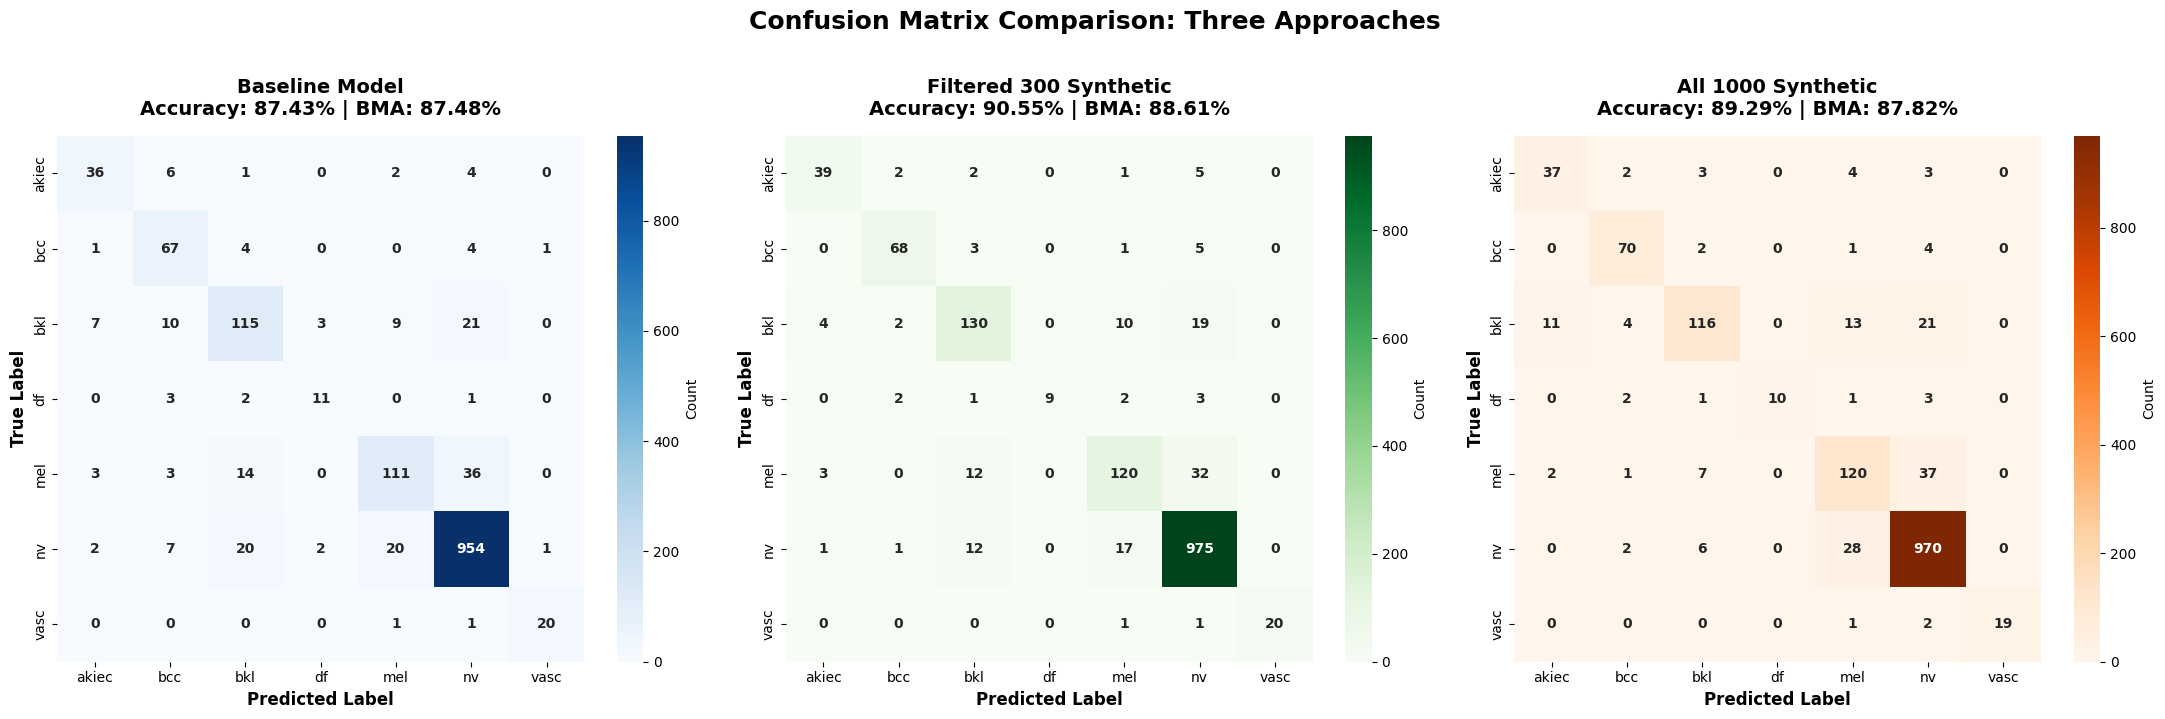

✓ High-quality confusion matrices saved!


In [29]:
# High-quality confusion matrices for presentation
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

class_names = list(idx_to_class.values())

# Baseline
sns.heatmap(results_baseline['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'}, annot_kws={'size': 10, 'weight': 'bold'})
axes[0].set_title(f'Baseline Model\nAccuracy: {results_baseline["accuracy"]*100:.2f}% | BMA: {results_baseline["bma"]*100:.2f}%',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Filtered (300)
sns.heatmap(results_augmented['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Count'}, annot_kws={'size': 10, 'weight': 'bold'})
axes[1].set_title(f'Filtered 300 Synthetic\nAccuracy: {results_augmented["accuracy"]*100:.2f}% | BMA: {results_augmented["bma"]*100:.2f}%',
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# All 1000
sns.heatmap(results_all_synthetic['confusion_matrix'], annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[2], cbar_kws={'label': 'Count'}, annot_kws={'size': 10, 'weight': 'bold'})
axes[2].set_title(f'All 1000 Synthetic\nAccuracy: {results_all_synthetic["accuracy"]*100:.2f}% | BMA: {results_all_synthetic["bma"]*100:.2f}%',
                  fontsize=14, fontweight='bold', pad=15)
axes[2].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison: Three Approaches', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(CLASSIFIER_OUTPUT_DIR / 'confusion_matrices_all_three.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ High-quality confusion matrices saved!")

# Visualize Overall Performance Metrics Bar Chart

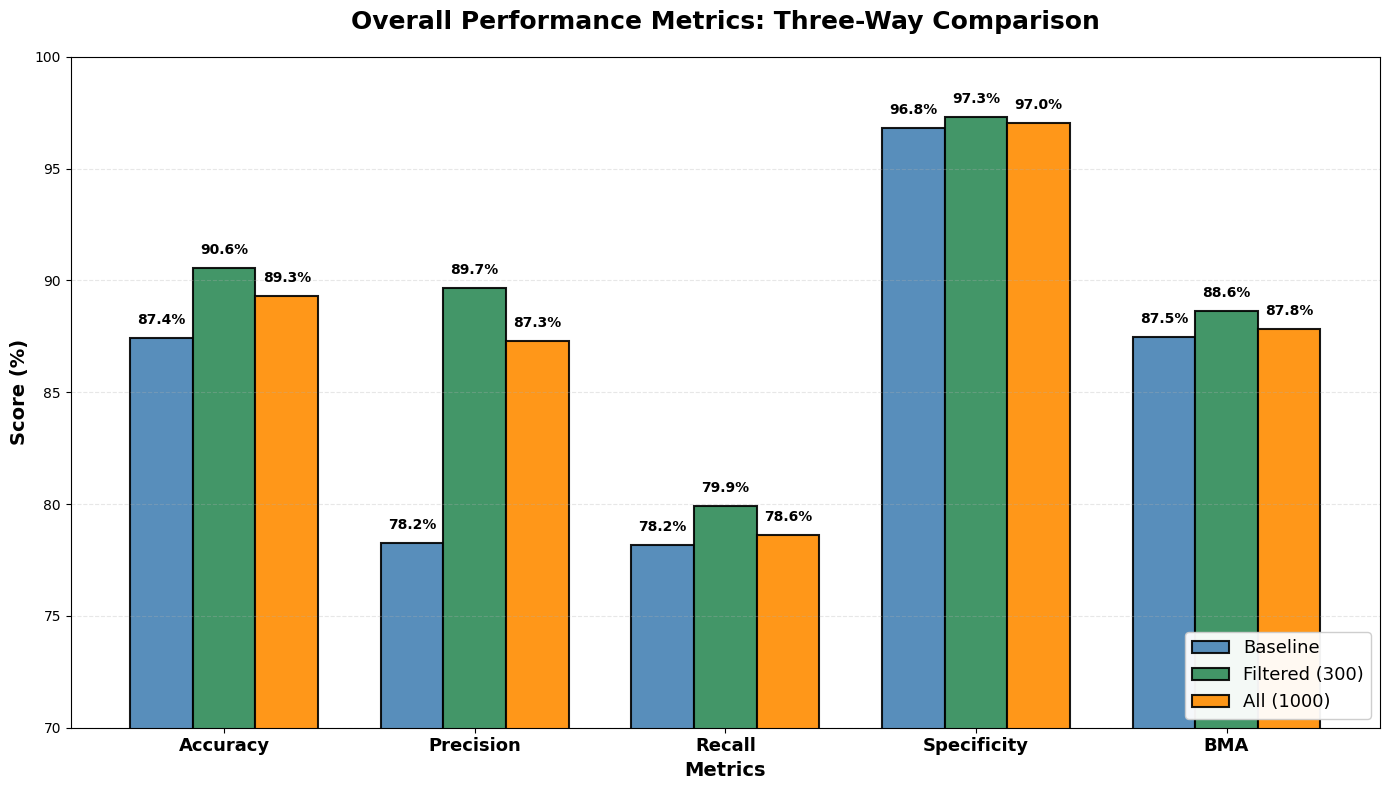

✓ Overall metrics chart saved!


In [30]:
# Professional bar chart for presentation
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'BMA']
baseline_scores = [
    results_baseline['accuracy'] * 100,
    results_baseline['precision_macro'] * 100,
    results_baseline['recall_macro'] * 100,
    np.mean(results_baseline['specificity']) * 100,
    results_baseline['bma'] * 100
]
filtered_scores = [
    results_augmented['accuracy'] * 100,
    results_augmented['precision_macro'] * 100,
    results_augmented['recall_macro'] * 100,
    np.mean(results_augmented['specificity']) * 100,
    results_augmented['bma'] * 100
]
all_scores = [
    results_all_synthetic['accuracy'] * 100,
    results_all_synthetic['precision_macro'] * 100,
    results_all_synthetic['recall_macro'] * 100,
    np.mean(results_all_synthetic['specificity']) * 100,
    results_all_synthetic['bma'] * 100
]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width, baseline_scores, width, label='Baseline',
               color='steelblue', alpha=0.9, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, filtered_scores, width, label='Filtered (300)',
               color='seagreen', alpha=0.9, edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + width, all_scores, width, label='All (1000)',
               color='darkorange', alpha=0.9, edgecolor='black', linewidth=1.5)

ax.set_title('Overall Performance Metrics: Three-Way Comparison', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=13, fontweight='bold')
ax.legend(fontsize=13, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim([70, 100])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(CLASSIFIER_OUTPUT_DIR / 'overall_metrics_three_way.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Overall metrics chart saved!")

# Visualize MEL Class Performance Across Three Models

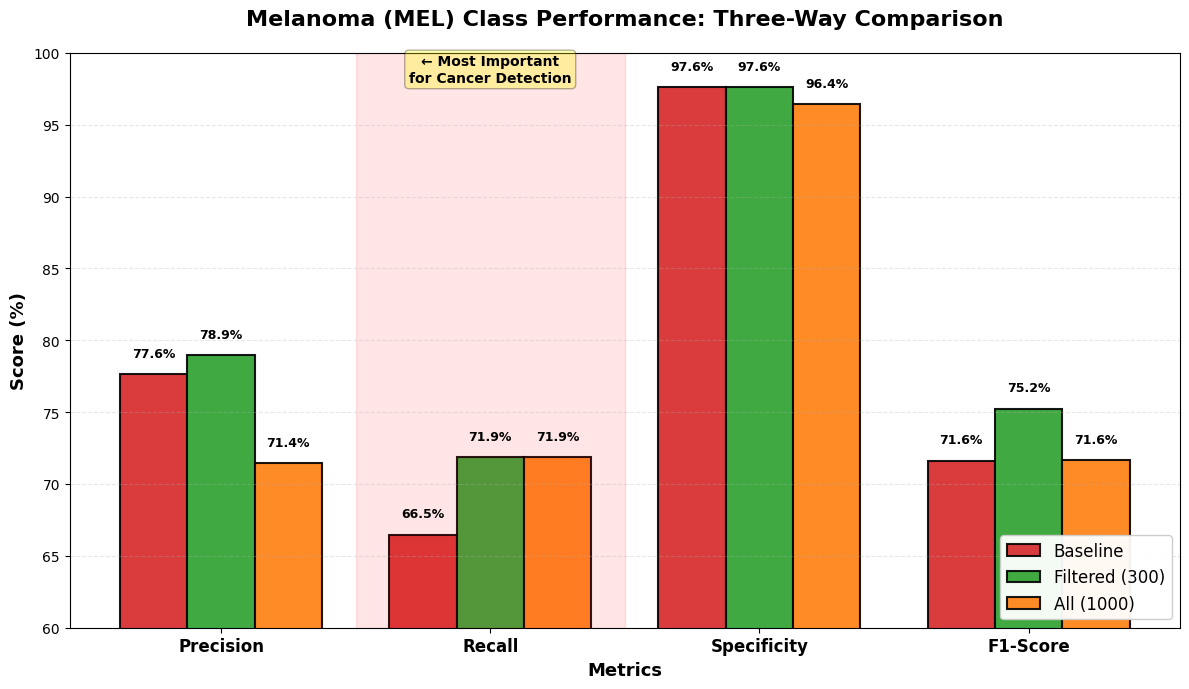

✓ MEL performance chart saved!


In [31]:
# MEL-specific performance visualization
mel_metrics = ['Precision', 'Recall', 'Specificity', 'F1-Score']
mel_baseline = [
    results_baseline['precision_per_class'][mel_idx] * 100,
    results_baseline['sensitivity'][mel_idx] * 100,
    results_baseline['specificity'][mel_idx] * 100,
    results_baseline['f1_per_class'][mel_idx] * 100
]
mel_filtered = [
    results_augmented['precision_per_class'][mel_idx] * 100,
    results_augmented['sensitivity'][mel_idx] * 100,
    results_augmented['specificity'][mel_idx] * 100,
    results_augmented['f1_per_class'][mel_idx] * 100
]
mel_all = [
    results_all_synthetic['precision_per_class'][mel_idx] * 100,
    results_all_synthetic['sensitivity'][mel_idx] * 100,
    results_all_synthetic['specificity'][mel_idx] * 100,
    results_all_synthetic['f1_per_class'][mel_idx] * 100
]

x = np.arange(len(mel_metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width, mel_baseline, width, label='Baseline',
               color='#d62728', alpha=0.9, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, mel_filtered, width, label='Filtered (300)',
               color='#2ca02c', alpha=0.9, edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + width, mel_all, width, label='All (1000)',
               color='#ff7f0e', alpha=0.9, edgecolor='black', linewidth=1.5)

ax.set_title('Melanoma (MEL) Class Performance: Three-Way Comparison',
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(mel_metrics, fontsize=12, fontweight='bold')
ax.legend(fontsize=12, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim([60, 100])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# Highlight Recall (most important for cancer detection)
ax.axvspan(0.5, 1.5, alpha=0.1, color='red', label='Critical Metric')
ax.text(1, 98, '← Most Important\nfor Cancer Detection',
        ha='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig(CLASSIFIER_OUTPUT_DIR / 'mel_performance_three_way.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ MEL performance chart saved!")

# Visualize Comprehensive Per-Class Metrics Comparison

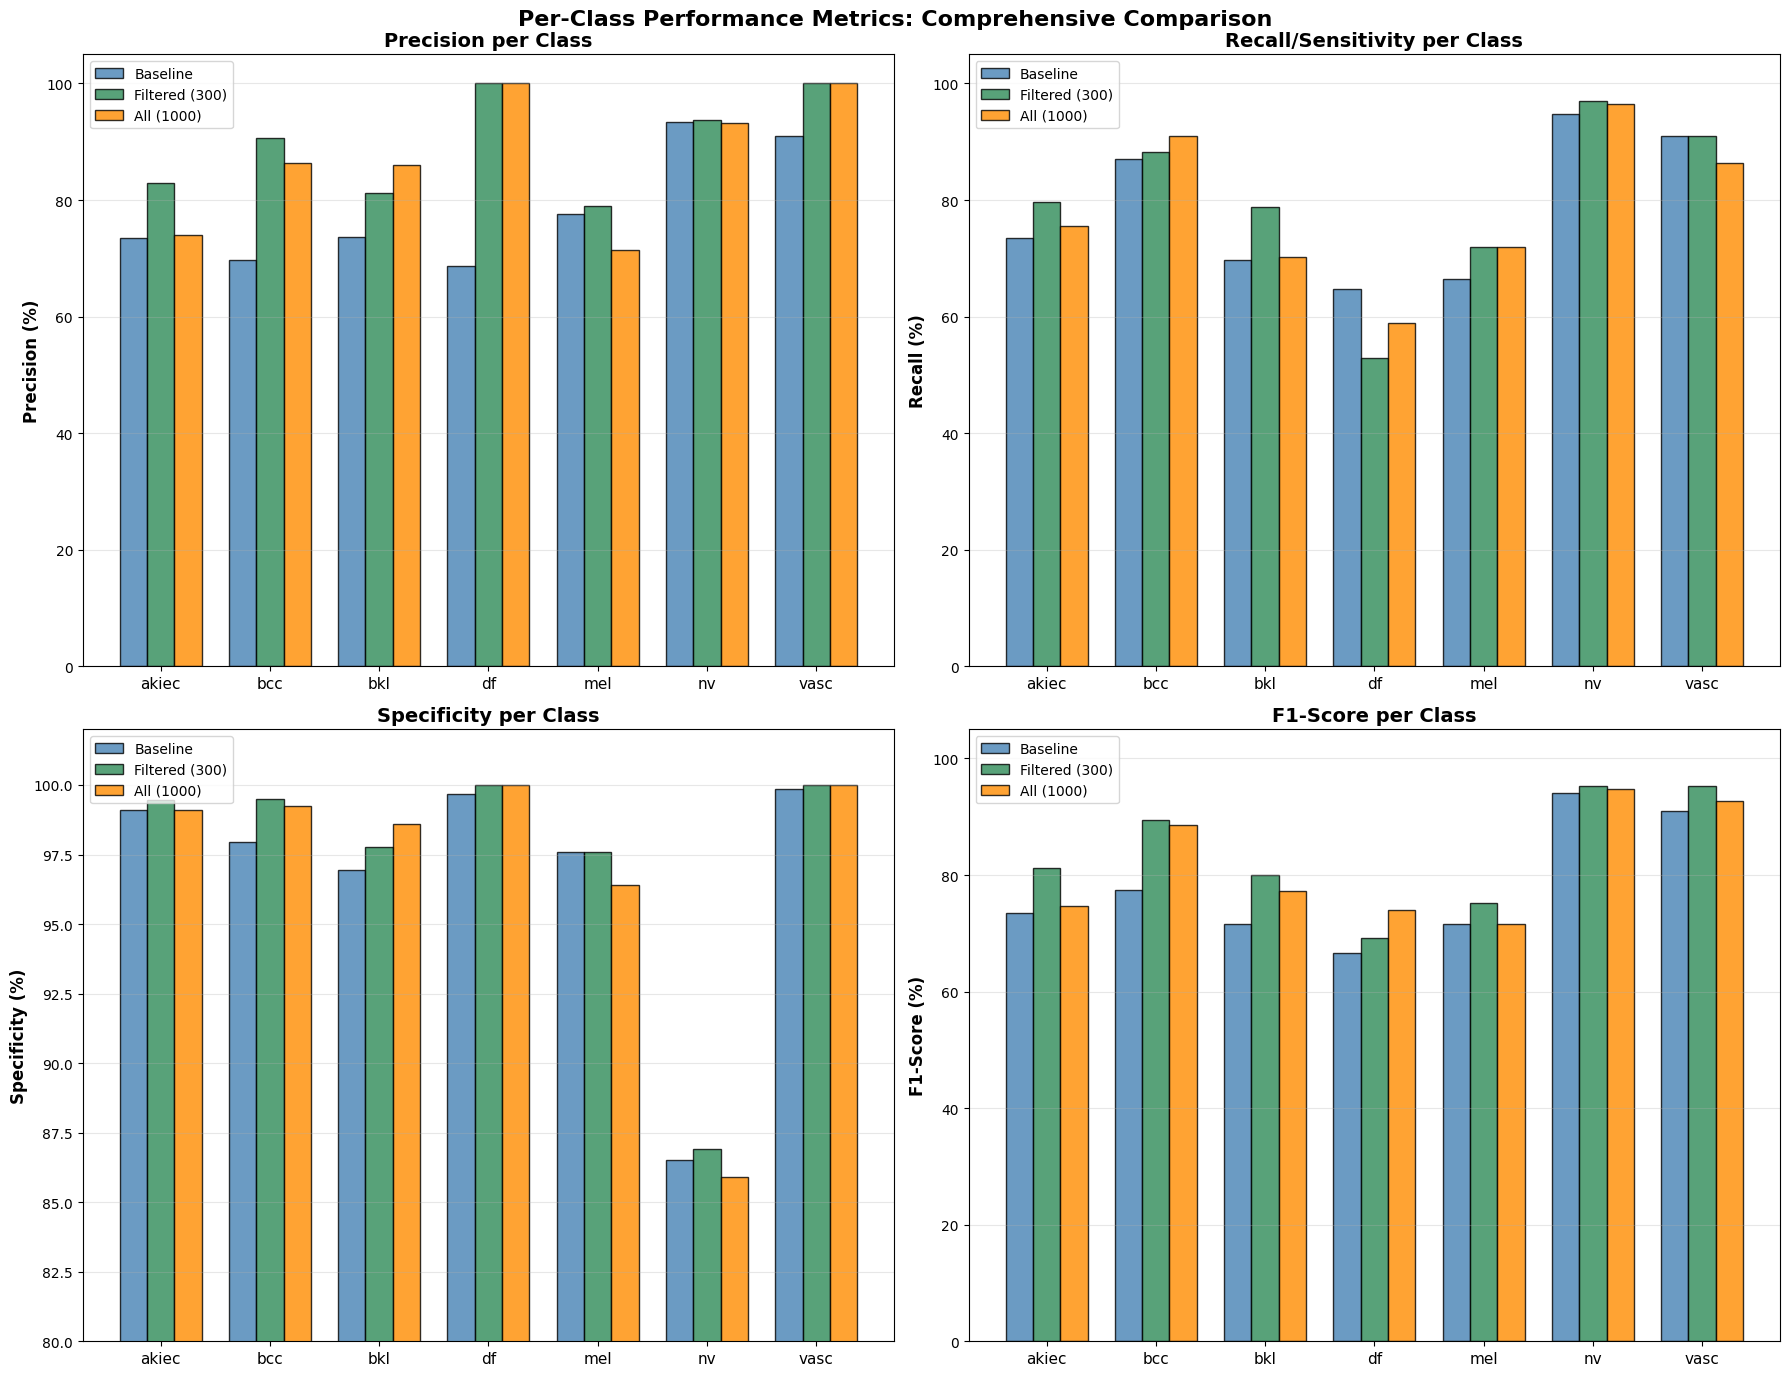

✓ Per-class metrics chart saved!


In [32]:
# Comprehensive per-class comparison
classes = list(idx_to_class.values())
x = np.arange(len(classes))
width = 0.25

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Precision
axes[0, 0].bar(x - width, results_baseline['precision_per_class']*100,
               width, label='Baseline', color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x, results_augmented['precision_per_class']*100,
               width, label='Filtered (300)', color='seagreen', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x + width, results_all_synthetic['precision_per_class']*100,
               width, label='All (1000)', color='darkorange', alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Precision per Class', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Precision (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(classes, rotation=0, fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 105])

# Recall
axes[0, 1].bar(x - width, results_baseline['sensitivity']*100,
               width, label='Baseline', color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x, results_augmented['sensitivity']*100,
               width, label='Filtered (300)', color='seagreen', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x + width, results_all_synthetic['sensitivity']*100,
               width, label='All (1000)', color='darkorange', alpha=0.8, edgecolor='black')
axes[0, 1].set_title('Recall/Sensitivity per Class', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Recall (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(classes, rotation=0, fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim([0, 105])

# Specificity
axes[1, 0].bar(x - width, results_baseline['specificity']*100,
               width, label='Baseline', color='steelblue', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x, results_augmented['specificity']*100,
               width, label='Filtered (300)', color='seagreen', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x + width, results_all_synthetic['specificity']*100,
               width, label='All (1000)', color='darkorange', alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Specificity per Class', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Specificity (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(classes, rotation=0, fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([80, 102])

# F1-Score
axes[1, 1].bar(x - width, results_baseline['f1_per_class']*100,
               width, label='Baseline', color='steelblue', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x, results_augmented['f1_per_class']*100,
               width, label='Filtered (300)', color='seagreen', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x + width, results_all_synthetic['f1_per_class']*100,
               width, label='All (1000)', color='darkorange', alpha=0.8, edgecolor='black')
axes[1, 1].set_title('F1-Score per Class', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(classes, rotation=0, fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim([0, 105])

plt.suptitle('Per-Class Performance Metrics: Comprehensive Comparison',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(CLASSIFIER_OUTPUT_DIR / 'per_class_metrics_all_three.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Per-class metrics chart saved!")

# Compare Training Curves Across All Three Models

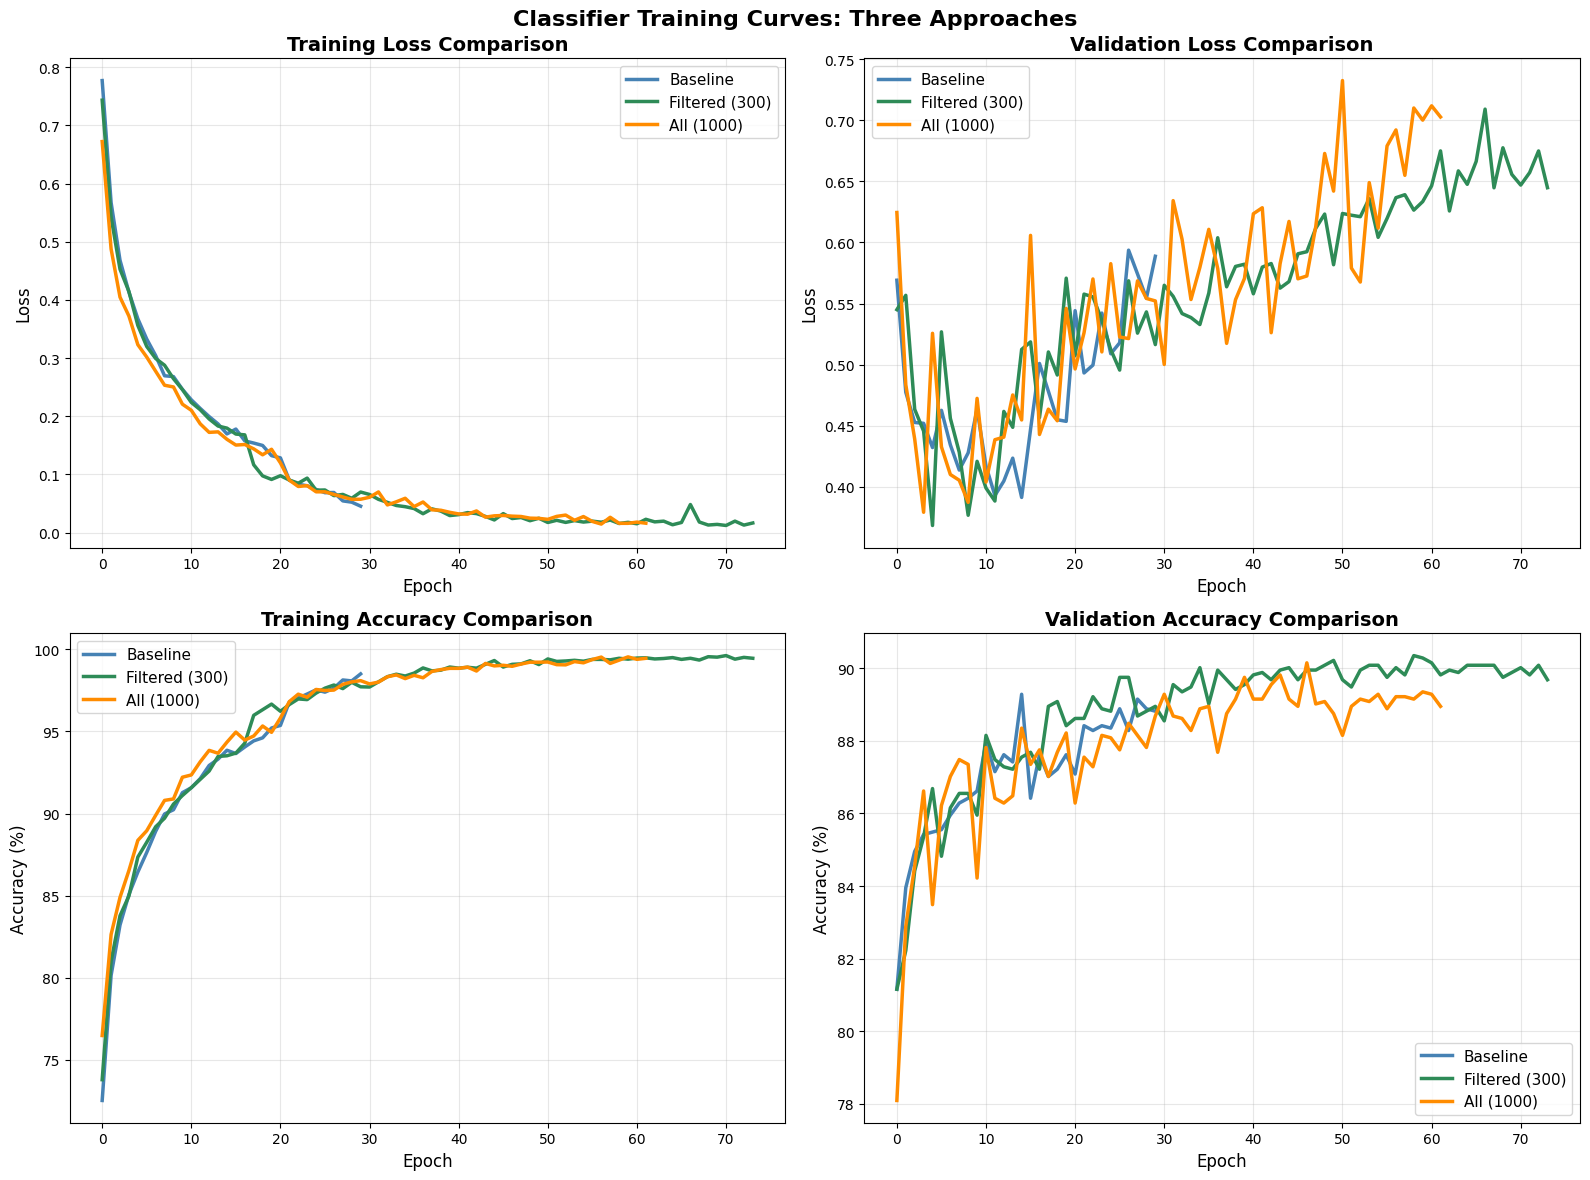

✓ Training curves comparison saved!


In [33]:
# Compare training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training Loss
axes[0, 0].plot(history_baseline['train_loss'], label='Baseline', linewidth=2.5, color='steelblue')
axes[0, 0].plot(history_augmented['train_loss'], label='Filtered (300)', linewidth=2.5, color='seagreen')
axes[0, 0].plot(history_all_synthetic['train_loss'], label='All (1000)', linewidth=2.5, color='darkorange')
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
axes[0, 1].plot(history_baseline['val_loss'], label='Baseline', linewidth=2.5, color='steelblue')
axes[0, 1].plot(history_augmented['val_loss'], label='Filtered (300)', linewidth=2.5, color='seagreen')
axes[0, 1].plot(history_all_synthetic['val_loss'], label='All (1000)', linewidth=2.5, color='darkorange')
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
axes[1, 0].plot(history_baseline['train_acc'], label='Baseline', linewidth=2.5, color='steelblue')
axes[1, 0].plot(history_augmented['train_acc'], label='Filtered (300)', linewidth=2.5, color='seagreen')
axes[1, 0].plot(history_all_synthetic['train_acc'], label='All (1000)', linewidth=2.5, color='darkorange')
axes[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1, 1].plot(history_baseline['val_acc'], label='Baseline', linewidth=2.5, color='steelblue')
axes[1, 1].plot(history_augmented['val_acc'], label='Filtered (300)', linewidth=2.5, color='seagreen')
axes[1, 1].plot(history_all_synthetic['val_acc'], label='All (1000)', linewidth=2.5, color='darkorange')
axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Classifier Training Curves: Three Approaches', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(CLASSIFIER_OUTPUT_DIR / 'training_curves_all_three.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves comparison saved!")